In [25]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

In [77]:
np.random.seed(42)

## 1. 2D data

### Evaluation Metrics

$MMD^2 (P, Q)= \mathbb{E}_{x,x' \sim P}[K(x,x')] + \mathbb{E}_{y,y'\sim Q}[K(y,y')] - 2 \mathbb{E}_{x\sim P,y\sim Q}[K(x,y)]$ 

In [27]:
def MMD(x, y, h=0.5, kernel='se'):
    '''MMD squared metric for two input distributions'''
    dxx = x[:, None, :] - x[None, :, :] 
    dyy = y[:, None, :] - y[None, :, :] 
    dxy = x[:, None, :] - y[None, :, :] 

    r2_xx = np.sum(dxx**2, axis=2)  # (n, n)
    r2_yy = np.sum(dyy**2, axis=2)  # (m, m)
    r2_xy = np.sum(dxy**2, axis=2)  # (n, m)

    if kernel == 'se':
        Kxx = np.exp(-r2_xx / h**2)
        Kyy = np.exp(-r2_yy / h**2)
        Kxy = np.exp(-r2_xy / h**2)

    if kernel =='imq':
        Kxx = 1.0 / np.sqrt(1 + r2_xx/h**2)
        Kyy = 1.0 / np.sqrt(1 + r2_yy/h**2)
        Kxy = 1.0 / np.sqrt(1 + r2_xy/h**2)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


## Model Definitions

### 2D Histogram

In [65]:
class Histogram:
    def __init__(self, n_bins):
        self.n_bins = n_bins
    
    def fit(self, X): 
        self.hist, self.edges = np.histogramdd(X, bins=self.n_bins) 
    
    def sample(self, n_sample):
        '''sample n points from fitted histogram'''
        # sample bins
        probs = self.hist.flatten() / self.hist.flatten().sum() # flatten to 1d & normalize TODO: is normalization necessary..?
        idx = np.random.choice(len(probs), size=n_sample, p=probs) # sample index
        ix, iy = np.unravel_index(idx, self.hist.shape) # recover 2d index

        # uniform sample points form selected bins
        xs = np.random.uniform(self.edges[0][ix], self.edges[0][ix+1])
        ys = np.random.uniform(self.edges[1][iy], self.edges[1][iy+1]) 

        return np.stack([xs, ys], axis=1)
    
    def score_samples(self, X):
        '''calculate the log probability of given points'''
        # fit points into bins
        x_bins = np.digitize(X[:,0], self.edges[0]) - 1
        y_bins = np.digitize(X[:,1], self.edges[1]) - 1
        idx = np.stack([x_bins, y_bins], axis=1)

        # check if X is between 0 and max value of histogram
        valid = (
                (idx[:,0]>=0) & (idx[:,0] < self.hist.shape[0]) & 
                (idx[:,1]>=0) & (idx[:,1] < self.hist.shape[1])
                 )
        
        p = np.zeros(len(X))
        p[valid] = self.hist[idx[valid,0], idx[valid,1]]

        return np.log(p + 1e-12) 

### Single Gaussian

In [66]:
class SingleGaussian:
    def fit(self, X):
        self.mean = X.mean(axis=0)
        self.cov = (X-self.mean).T @ (X-self.mean)/ len(X)  # TODO: compare with np.cov(X, rowvar=False)
        self.inv_cov = np.linalg.inv(self.cov)
        self.det = np.linalg.det(self.cov)

    def sample(self, n_samples):
        '''sample n points from fitted single Gaussian distribution'''
        samples = np.random.multivariate_normal(self.mean, self.cov, n_samples)
        return samples
    
    def score_samples(self, X):
        '''calculates probability of the given data'''
        diff = X - self.mean # (x - \mu)
        exponent = np.sum(diff @ self.inv_cov * diff, axis=1) # (N,2) @ (2,2) * (2,2) --> (N,2) --> (N,1)
        log_p = -0.5 * ( X.shape[1] * np.log(2*np.pi) + np.log(self.det) + exponent )
        return log_p


### Gaussian Mixture Model

In [67]:
class GMM:
    def __init__(self, n_components=3, n_iter=50):
        self.K = n_components
        self.n_iter = n_iter
    
    def fit(self, X):
        n, d = X.shape

        # initialize model
        idx = np.random.choice(n, self.K, replace=False)
        self.means = X[idx] # randomly chosen means
        cov = [(X-X.mean(axis=0)).T @ (X-X.mean(axis=0))/ len(X) ] # global covariance
        self.cov = np.array(cov*self.K)
        self.weights = np.ones(self.K)/self.K # equal weights

        for i in range(self.n_iter):
            # E-step: calculate prob of each point belongs to kth Gaussian component
            post = np.zeros([n,self.K]) 
            for k in range(self.K): 
                diff = X - self.means[k] # TODO: can I write it as vector computation?
                inv_cov = np.linalg.inv(self.cov[k])
                det_cov = np.linalg.det(self.cov[k])
                exponent =  -0.5 * np.sum(diff @ inv_cov * diff, axis=1) # (n,)
                post[:,k] = self.weights[k] * np.exp(exponent) / (np.sqrt(2*np.pi)**d * det_cov)
            norm =  post.sum(1, keepdims=True) 
            norm[norm==0] = 1e-12 # numerical stability
            post = post / norm
            

            # M-step: update mean, cov and weights
            Nk = post.sum(0) # n_samples belong to each component
            self.weights = Nk/n
            self.means = (post.T @ X) / Nk[:,None] 
            for k in range(self.K):
                diff = X - self.means[k]
                self.cov[k] = (post[:,k,None]*diff).T @ diff /Nk[k]
                self.cov[k] += np.eye(d) * 1e-6  # prevent singular matrix
                
    def sample(self, n_sample):
        '''sample n points from fitted GMM'''
        ks = np.random.choice(self.K, size=n_sample, p=self.weights) # sample component
        samples = []
        for k in range(self.K):
            n_k = np.sum(ks == k)
            samples.append(np.random.multivariate_normal(self.means[k], self.cov[k], n_k))
        return np.vstack(samples)

    def score_samples(self, X):
        '''calculates probability of the given data'''
        n, d = X.shape
        probs = np.zeros((n,self.K)) # prob xi belongs to each kth Gaussian
        for k in range(self.K):
            diff = X - self.means[k]
            inv_cov = np.linalg.inv(self.cov[k])
            det_cov = np.linalg.det(self.cov[k])
            exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
            probs[:,k] = self.weights[k] * np.exp(exponent) / (np.sqrt((2*np.pi)**d * det_cov))
        log_p = np.log(probs.sum(1)+1e-12)
        return log_p

### KDE

In [ ]:
class KDE:
    def __init__(self, bandwidth=0.1):
        self.h = bandwidth

    def fit(self, X):
        self.X = X

    def sample(self, n_samples):
        '''sample n points. Sample n points from Gaussian distribution around sampled x'''
        idx = np.random.choice(len(self.X), size=n_samples)  
        xs = self.X[idx]
        epsilon = np.random.randn(n_samples, 2) * self.h 
        return xs + epsilon

    def score_samples(self, X): 
        '''calculates probability of the given data'''
        diff = X[:,None,:] - self.X[None,:,:]
        sqdist = np.sum(diff**2, axis=2) # TODO: check
        kern = np.exp(-0.5*sqdist/self.h**2)
        p = kern.mean(1)/ (2*np.pi * self.h**2)
        return np.log(p + 1e-12)

## Evaluate Models

In [94]:
def eval_mmd(model_class, param_name, param_values, x_train, x_test):
    """Evaluate MMD^2 for a sequence of hyperparameter values"""
    results = []
    times = []
    for val in param_values:
        kwargs = {param_name: val}
        model = model_class(**kwargs)

        t0 = time.time()
        model.fit(x_train)
        Y = model.sample(500)
        t_fit_sample = time.time() - t0

        mmd = MMD(x_test, Y, kernel='se', h=0.5)
        results.append(mmd)
        times.append(t_fit_sample)
    return np.array(results), np.array(times)


In [95]:
# load data
x, _ = make_moons(n_samples=2000, noise=0.1)
print('X shape: ', x.shape)

x_train, x_test = train_test_split(x, test_size=0.2)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)

X shape:  (2000, 2)
x_train shape:  (1600, 2)
x_test shape:  (400, 2)


In [123]:
hist_bins = np.arange(10,50,2) # num_bins
gmm_K = range(1,20) # num_components
kde_h = [0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.8] # kernel band width

mmd_hist, t_hist = eval_mmd(Histogram, "n_bins", hist_bins, x_train, x_test)
mmd_gmm, t_gmm = eval_mmd(GMM, "n_components", gmm_K, x_train, x_test)
mmd_kde, t_kde = eval_mmd(KDE, "bandwidth", kde_h, x_train, x_test)

gauss = SingleGaussian()
t0 = time.time()
gauss.fit(x_train) 
Y_gauss = gauss.sample(500) # gaussian generated samples
t_gauss = time.time() - t0
mmd_gauss = MMD(x_test, Y_gauss, kernel='se', h=0.5) # gaussian mmd score

### $MMD^2$ vs hyperparameters

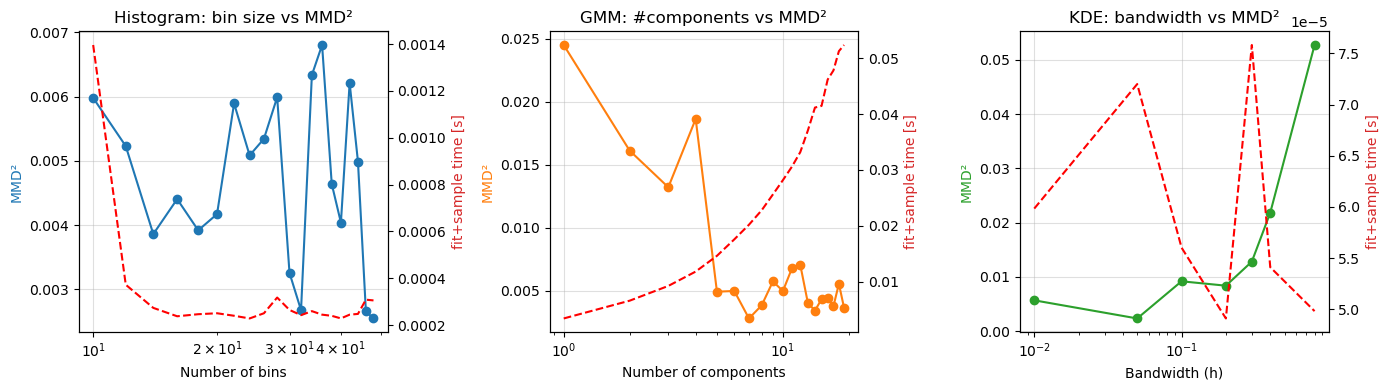

Single Gaussian: MMD² = 0.0286 (fit+sample: 0.000s)


In [124]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Histogram
ax = axes[0]
ax.plot(hist_bins, mmd_hist, 'o-', color='tab:blue', label='MMD²')
ax.set_xscale('log')
ax.set_xlabel('Number of bins')
ax.set_ylabel('MMD²', color='tab:blue')
ax.set_title('Histogram: bin size vs MMD²')
ax.grid(True, alpha=0.4)

ax_t = ax.twinx()
ax_t.plot(hist_bins, t_hist, 'r--', label='time [s]')
ax_t.set_ylabel('fit+sample time [s]', color='tab:red')

# GMM 
ax = axes[1]
ax.plot(gmm_K, mmd_gmm, 'o-', color='tab:orange', label='MMD²')
ax.set_xscale('log')
ax.set_xlabel('Number of components')
ax.set_ylabel('MMD²', color='tab:orange')
ax.set_title('GMM: #components vs MMD²')
ax.grid(True, alpha=0.4)

ax_t = ax.twinx()
ax_t.plot(gmm_K, t_gmm, 'r--', label='time [s]')
ax_t.set_ylabel('fit+sample time [s]', color='tab:red')

# KDE 
ax = axes[2]
ax.plot(kde_h, mmd_kde, 'o-', color='tab:green', label='MMD²')
ax.set_xscale('log')
ax.set_xlabel('Bandwidth (h)')
ax.set_ylabel('MMD²', color='tab:green')
ax.set_title('KDE: bandwidth vs MMD²')
ax.grid(True, alpha=0.4)

ax_t = ax.twinx()
ax_t.plot(kde_h, t_kde, 'r--', label='time [s]')
ax_t.set_ylabel('fit+sample time [s]', color='tab:red')

plt.tight_layout()
plt.show()

print(f"Single Gaussian: MMD² = {mmd_gauss:.4f} (fit+sample: {t_gauss:.3f}s)")


#### Comment on the result

1. Histogram: MMD^2 decreases as the number of bins increases until 20, as the model becomes more expressive. However, beyond 20, MMD^2 slightly increases, reflecting the overfitting. 
optimal bin size ~ 20

2. GMM: Increasing the number of bins reduces MMD^2, and the gain saturates around k=5. Around k > 10, there is no more improvements in the performance, indicating redundant mixture components. Computational cost grows with K. 
optimal k ~ 5

3. KDE: h > 0.1 results high MMD^2, indicating overssmooothing. 
optimal h ~ 0.1. Runtime is nearly constant, as KDE complexity depends mainly on the sample size. 

4. Single Gaussian: resulted highest MMD^2 score among all models, and agrees with GMM with k=1. 

### Generated samples

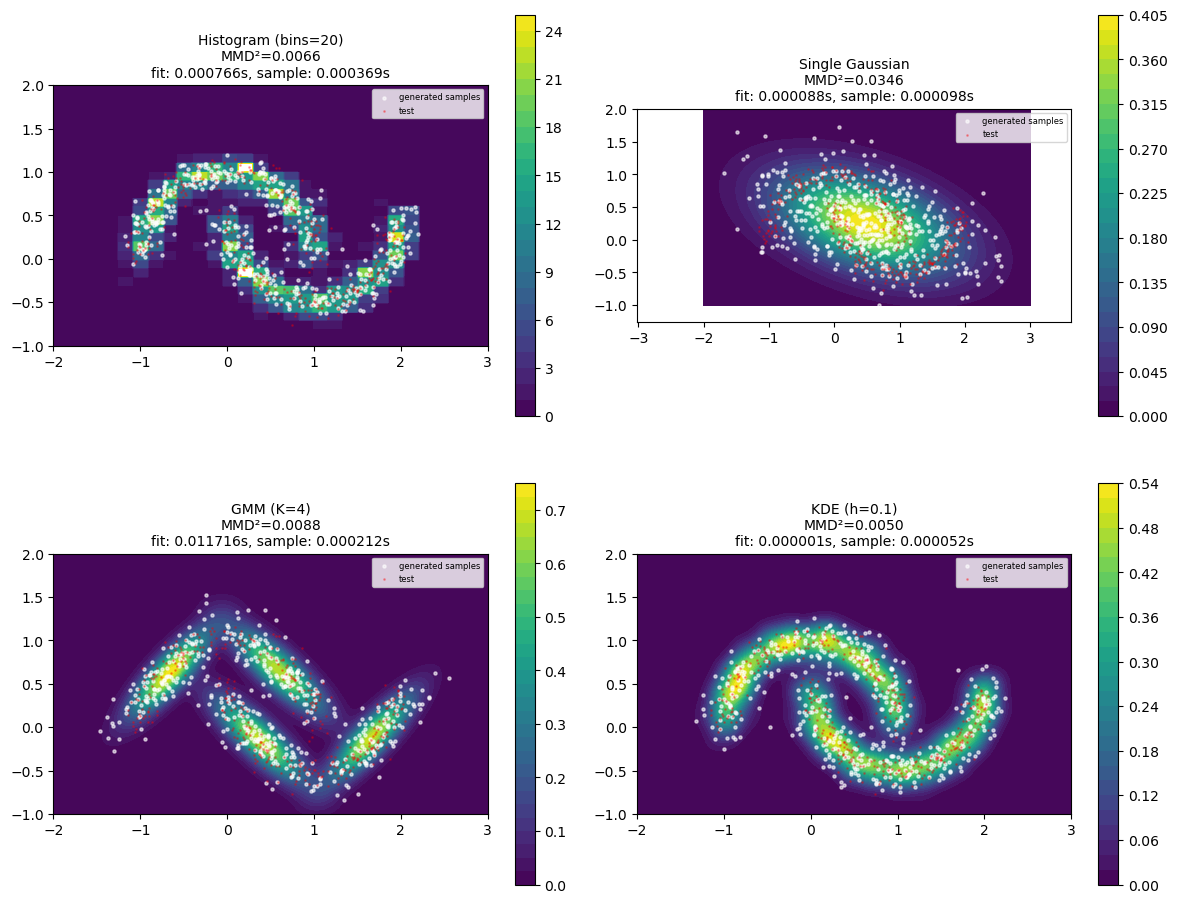

In [75]:
models = [
    (Histogram(20), "Histogram (bins=20)"),
    (SingleGaussian(), "Single Gaussian"),
    (GMM(4), "GMM (K=4)"),
    (KDE(0.1), "KDE (h=0.1)")
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (Model, name) in enumerate(models):
    ax = axes[i]
    model = Model

    # measure time
    t0 = time.time()
    model.fit(x_train)
    t_fit = time.time() - t0

    t1 = time.time()
    Y = model.sample(500)
    t_sample = time.time() - t1

    mmd = MMD(x_test, Y, kernel='se', h=0.5)

    # evaluate density at each grid points
    xx, yy = np.meshgrid(np.linspace(-2, 3, 200),
                         np.linspace(-1, 2, 200))
    grid = np.column_stack([xx.ravel(), yy.ravel()])
    zz = np.exp(model.score_samples(grid)).reshape(xx.shape)
    cs = ax.contourf(xx, yy, zz, levels=30, cmap='viridis')
    plt.colorbar(cs, ax=ax, shrink=0.8)

    # sampled points
    ax.scatter(Y[:, 0], Y[:, 1], s=5, c='white', alpha=0.6, label='generated samples')
    ax.set_aspect('equal')

    ax.set_title(
        f"{name}\n"
        f"MMD²={mmd:.4f}\n"
        f"fit: {t_fit:.6f}s, sample: {t_sample:.6f}s",
        fontsize=10
    )

    ax.scatter(x_test[:,0], x_test[:,1], s=1, c='red', alpha=0.3, label='test')
    ax.legend(loc='upper right', fontsize=6)

plt.tight_layout()
plt.show()


#### Comments

1. Histogram (bins=20) caputres the topology of the dataset generally well, yielding MMD^2=0.006. The density trainsition are abrupt due to bin discretization. 
2. Single Gaussian produces distribution centered near the global dataset mean, and fails to reproduce the structure. This is represented in high MMD^2 = 0.0346
3. GMM (k=4) successfully separates the two half-moons, but three are some overlap between the two modes. 
4. KDE (h=0.1) produces smooth density follows the shape of two-moon structure, and resulted in the lowest MMD^2 ~ 0.0050. KDE captures nonlinear geometry effectively. 

<div style="color: green; font-weight:
bold">
In general, all of our model classes reproduces the result of sample solution for density estimation and sampling, and MMD^2 scores, only differs by small details.

1. Histogram: Our implementation vectorized the sampling process resulting faster evaluation. However, our histogram predicts non-smooth probability density as we do not add noise, and it results slightly lower accuracy. 
2. Single Gaussian: Essentially the same as the sample solution. 
3. GMM: Our GMM slightly underperforms, due to different initialization before EM step. Our initial means are chosen randomly rather than k-means and the initial covariances are set to be the same for all the components. EM step implementation is the same. 
4. KDE: Similar, but our sampling process is vectorized and performs faster. 

Our implementation is in general simpler and faster, but less stabilized. 
 </div> 

## 2) Higher-Dimensional Data

In [ ]:
import sklearn
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from density_forest import DensityForest

In [ ]:
digits = sklearn.datasets.load_digits()
X = digits.data
y = digits.target

X = X/16 #normalize

X_train, X_test, y_train, y_test = train_test_split(X, y)

models = {
    "Single Gaussian": GaussianMixture(n_components = 1),
    "GMM": GaussianMixture(n_components = 10),
    "KDE": KernelDensity(bandwidth = 2.0),
    "Density Forest": DensityForest(n_trees = 30, n_min = 5)
}

<div style="color: green; font-weight:bold"> Bugs: There was no need to normalize X here. Density forest was incorrectly initialized. It should be DensityForest(n_min = 5) and dforest.fit(X_train). N_components for the Gaussian Mixture should be more than just 1. All models should have had better hyperparameters based on the dataset. </div>

In [ ]:
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train)

Training Single Gaussian...
Training GMM...
Training KDE...
Training Density Forest...


In [ ]:
def squared_exponential_kernel (X, Y, h = 0.1):
    X_norm = np.sum(X**2, axis = 1, keepdims = True)
    Y_norm = np.sum(Y**2, axis = 1, keepdims = True).T
    dist = X_norm + Y_norm - 2 * X @ Y.T
    return np.exp(-dist/(2*(h**2)))

def inverse_multiquadratic_kernel(X,Y, h = 0.1):
    X_norm = np.sum(X**2, axis = 1, keepdims = True)
    Y_norm = np.sum(Y**2, axis = 1, keepdims = True).T
    dist = X_norm + Y_norm - 2* X @ Y.T
    return 1.0 / (1.0 + dist/(h**2))

def mmd2(X, Y, kernel_fn, h):
    XX = kernel_fn(X,X, h)
    YY = kernel_fn(Y,Y,h)
    XY = kernel_fn(X,Y,h)
    x = X.shape[0]
    y = Y.shape[0]
    mmd2 = XX.sum()/(x*x) + YY.sum()/(y*y) - 2*XY.sum()/(x*y)
    return mmd2

In [ ]:
#Evaluate Models
for name, model in models.items():
    x_len = len(X_test)
    X_generated = model.sample(x_len)
    if isinstance(X_generated,tuple):
        X_generated = model.sample(x_len)[0]
    else:
        X_generated
        
    if hasattr(model, "score_samples"):
        scores = model.score_samples(X_test)
        if np.mean(scores)<0:
            dens_test = np.exp(scores)
        else:
            dens_test = scores
            mean_dens_test = np.mean(dens_test)
        mean_dens_test = np.mean(dens_test)
    else:
        mean_dens_test = np.nan

    mmd2_sek = mmd2(X_generated, X_test, squared_exponential_kernel, 1.0)
    mmd2_imk = mmd2(X_generated, X_test, inverse_multiquadratic_kernel, 1.0)

    print(f"{name}:")
    print(f"Mean Test Density: {mean_dens_test:.4f}")
    print(f"MMD^2 Squared Exponential Kernel: {mmd2_sek:.4f}\nMMD^2 Inverse Multiquadratic Kernel: {mmd2_imk:.4f}")
    print("_____________________________________")

Single Gaussian:
Mean Test Density: 69.0596
MMD^2 Squared Exponential Kernel: 0.0110
MMD^2 Inverse Multiquadratic Kernel: 0.0074
_____________________________________
GMM:
Mean Test Density: 99.9445
MMD^2 Squared Exponential Kernel: 0.0066
MMD^2 Inverse Multiquadratic Kernel: 0.0053
_____________________________________
KDE:
Mean Test Density: 0.0000
MMD^2 Squared Exponential Kernel: 0.0315
MMD^2 Inverse Multiquadratic Kernel: 0.1059
_____________________________________
Density Forest:
Mean Test Density: nan
MMD^2 Squared Exponential Kernel: 0.0066
MMD^2 Inverse Multiquadratic Kernel: 0.0056
_____________________________________


<div style="color: green; font-weight:bold"> Bugs: The sampling is incorrect. model.sample(x_len) is incorrect so the output is not properly used for some models. There should be sampling for each model (for example, kde_samples = kde.sample(n_samples), gmm_samples = gmm.sample(n_samples)[0]).</div>

<div style="color: green; font-weight:bold">For KDE, the values for the MMD^2 squared exponential kernel and the inverse multiquadratic kernel seem larger compared to the values in the sample solution.</div>

### Comments
1. Single Gaussian's mean test density is pretty high which shows it has a good likelihood for the test data. It also has low MMD^2 values which implies that the generated samples are close to the test data.
2. GMM has the highest mean test density which means it has the best likelihood out of all the models for the test data. It's MMD^2 scores are the lowest which implies that the generated samples were most similar to the test data.
3. KDE has either a zero mean test density or a very close to zero mean test density. The MMD^2 values are also higher than the other models. Both of these imply that there is a great discrepancy between the KDE sample data and the test data.
4. Density Forest doesn't have a mean test density since it doesn't have a scored_samples attribute. It's low MMD^2 scores show that the generated samples are close to the test data.

Random Forest Classifier
Train Accuracy: 1.0000, Test Accuracy: 0.9733
Single Gaussian


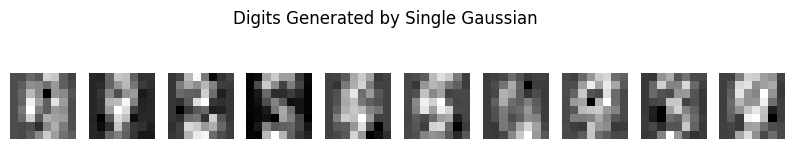

GMM


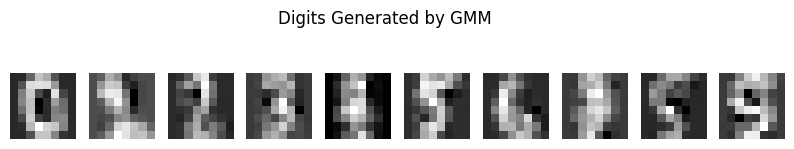

KDE


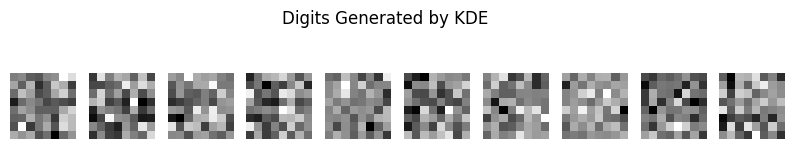

Density Forest


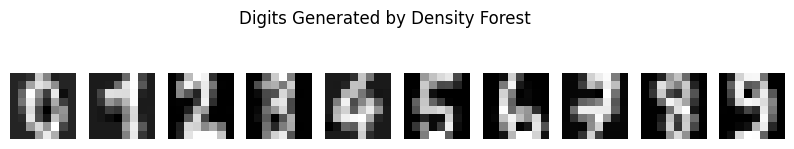

In [ ]:
#Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
train_accuracy = rf.score(X_train, y_train)
test_accuracy = rf.score(X_test, y_test)

print(f"Random Forest Classifier\nTrain Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

for name, model in models.items():
    X_sample = model.sample(1000)
    if isinstance(X_sample, tuple):
        X_generated = X_sample[0] 
    else:
        X_generated = X_sample
    preds = rf.predict(X_generated)

    print(f"{name}")
    fig, axes = plt.subplots(1, 10, figsize = (10,2))

    for i in range(10):
        if np.any(preds == i):
            axes[i].imshow(X_generated[preds == i][0].reshape(8,8), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Digits Generated by {name}")
    plt.show()


<div style="color: green; font-weight:bold"> There's no histogram plots showing the probability of each number for each model. Depending on the model, these plots show both good and bad hyperparameters. KDE, GMM, and Single Gaussian have bad parameters while the Density Forest has good parameters. There should be visuals of both good and bad parameters for each model.</div>

### Comments
1. Single Gaussian has some noise but it is still possible to barely make out the shape of the digit.
2. GMM is a little less noisy than single gaussian and it is a bit easier to see the shape of the digits.
3. KDE has a lot of noise and it is impossible to determine what digits are present.
4. Density Forest has minimal noise and it is very easy to see the shapes of the digits.

<div style="color: green; font-weight:bold"> Overall, the hyperparameters are too simplistic, which underfits the data. If there were better hyperparameters based on the dataset, then the models would produce results more similar to the sample solution. However, this code was still able to show the differences between each model and how hyperparameters affect how well a model works.</div>